# Small data and deep learning
This pratical session proposes to study several techniques to improve training performance in the challenging context where few data and resources are available.

# Introduction
Assume we are in a context where few "gold" labeled data are available for training, say $\mathcal{X}_{\text{train}}\triangleq\{(x_n,y_n)\}_{n\leq N_{\text{train}}}$, where $N_{\text{train}}$ is small. A large test set $\mathcal{X}_{\text{test}}$ is available. A large amount of unlabeled data, $\mathcal{X}_{\text{nolabel}}$, is available. We also assume that we have a limited computational budget (e.g., no GPUs).

For each question, write a commented *Code* or a complete answer as a *Markdown*. When the objective of a question is to report a CNN accuracy, please use the following format to report it, at the end of the question :


| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   XXX  | XXX | XXX | XXX |


If applicable, please add the field corresponding to the  __Accuracy on Full Data__ as well as a link to the __Reference paper__ you used to report those numbers. (You do not need to train a CNN on the full CIFAR10 dataset.)

In your final report, please keep the logs of each training procedure you used. We will only run this jupyter if we have some doubts on your implementation. 

__The total file sizes should be reasonable (feasible with 2MB only!). You will be asked to hand in the notebook, together with any necessary files required to run it if any.__


To run your experiments, you can use the same local installation as for previous TPs, or otherwise https://colab.research.google.com/.

In [ ]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
import time

## Training set creation
__Question 1 (2 points) :__ Propose a dataloader that will only use the first 100 samples of the CIFAR-10 training set. 

*Hint* : You can modify the file located at https://github.com/pytorch/vision/blob/master/torchvision/datasets/cifar.py or use the information from https://pytorch.org/vision/stable/datasets.html

This is our dataset $\mathcal{X}_{\text{train}}$, it will be used until the end of this project. The remaining samples correspond to $\mathcal{X}_{\text{nolabel}}$. The testing set $\mathcal{X}_{\text{test}}$ corresponds to the whole testing set of CIFAR-10.

In [ ]:
# In this question, we use the Subset class of utils.data to consider the first 100 samples of CIFAR-10
# Our unlabeled dataset is also generated using this method

# CIFAR-10 needs to be transformed to torch Tensor and normalized
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Downloading full train dataset
cifar_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)

# Splitting into first 100 images and the rest
train_dataset = torch.utils.data.Subset(cifar_dataset, range(100))
nolabel_dataset = torch.utils.data.Subset(cifar_dataset, range(100,len(cifar_dataset)))

# Downloading full test dataset
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
print("Train set size:",len(train_dataset))
print("Unlabeled set size:",len(nolabel_dataset))
print("Test set size:",len(test_dataset))

Train set size: 100
Unlabeled set size: 49900
Test set size: 10000


## Testing procedure
__Question 2 (1.5 points) :__ Explain why the evaluation of the training procedure is difficult. Propose several solutions.

It will be difficult to evaluate or training as we don't have enough labeled data. As a result, the model won't learn enough features as the test set will likely be more diverse. The model don't have enough pictures to learn from. Several solutions are available, all discussed during the last lecture:


*   Data augmentation: add various transformation(geometric transformation or value-based transformation) in order to add new samples. We could also use a simulator that generates a lot of dara but a question of realism arise.
*   Multi-tasking: if we have an auxiliary task on the same data, we could use the auxiliary one for our main task that have few data. The task must be close enough. Features of the auxiliary task shoud be usefull if the task is close enough and the input come from the same space.
*   Transfer learning: here it is more about a 'sequential' training. We train a first a model on a bigger dataset for the same or a similar task. Then we use this pretrained model, fine tune the last layers to adapt it to our outputs. Time efficient and accurate.

Here we assume that we have an isse regarding a small number oof data as we have only 100 pictures labeled. We don't assume that it is a problem of few labeled examples so we won't talk about semi-supervision, weak-supervision, self-supervision or active learning.

# Raw approach: the baseline

In this section, the goal is to train a CNN on $\mathcal{X}_{\text{train}}$ and compare its performance with reported numbers from the litterature. You will have to re-use and/or design a standard classification pipeline. You should optimize your pipeline to obtain the best performances (image size, data augmentation by flip, ...).

The key ingredients for training a CNN are the batch size, as well as the learning rate schedule, i.e. how to decrease the learning rate as a function of the number of epochs. A possible schedule is to start the learning rate at 0.1 and decreasing it every 30 epochs by 10. In case of divergence, reduce the learning rate. A potential batch size could be 10, yet this can be cross-validated.

You can get some baselines accuracies in this paper : http://openaccess.thecvf.com/content_cvpr_2018/papers/Keshari_Learning_Structure_and_CVPR_2018_paper.pdf. Obviously, it is a different context for those researchers who had access to GPUs.

## ResNet architectures

__Question 3 (4 points) :__ Write a classification pipeline for $\mathcal{X}_{\text{train}}$, train from scratch and evaluate a *ResNet-18* architecture specific to CIFAR10 (details about the ResNet-18 model, originally designed for the ImageNet dataset, can be found here: https://arxiv.org/abs/1512.03385). Please report the accuracy obtained on the whole dataset as well as the reference paper/GitHub link.

*Hint:* You can re-use the following code: https://github.com/kuangliu/pytorch-cifar. During a training of 10 epochs, a batch size of 10 and a learning rate of 0.01, one obtains 40% accuracy on $\mathcal{X}_{\text{train}}$ (\~2 minutes) and 20% accuracy on $\mathcal{X}_{\text{test}}$ (\~5 minutes).

We use the code taken from https://github.com/kuangliu/pytorch-cifar to build our ResNet-18 architecture.

In [ ]:
# Implement the ResNet basic block composed of two successive convolutions summed 
# with a short-cut connection (with ReLU activation)
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        # Pass through two convolutional layers
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            ) # Short-cut layer

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x) # Sum convolutions with shortcut layer
        out = F.relu(out)
        return out

In [ ]:
# Build ResNet model
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, out.size(2))
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

ResNet-18 is a sub-class of the general ResNet architecture (cf. https://arxiv.org/abs/1512.03385). 18 stands for the number of layers it is composed of. It's elementary blocks are basics (as opposed to bottleneck's for architectures such as ResNet-50). 

Basic blocks are a succession of two convolutions of kernel size 3x3 (in the ResNet-18 case). The first downsamples image size by 2 (use of stride 2 convolution). The second maintains image size (stride 1 convolution with padding). Each convolution output is passed through a batch-norm layer and relu activation. Finally, a short-cut connection is added to the output. The latter contains a convolutional layer in case image size needs to be downsampled (like it is the case for ResNet-18).

The ResNet-18 architecture is a succession of 4 blocks each composed of 2 basic blocks. The number of feature maps increases from 64, 128, 256, to 512 at each of these blocks.

We can thus define a ResNet-18 model from our ResNet implementation:

In [ ]:
def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2])

We start by training our model on the small training set and using the parameters suggested in the question (10 epochs, batch size 10, learning rate 0.001):

In [ ]:
# Instantiate DataLoaders
batch_size = 10
torch.manual_seed(0) # Set random seed for reproducibility purposes

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                            shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                            shuffle=False, num_workers=2)

In [ ]:
# Instantiate model without using GPU power
resnet = ResNet18()

In [ ]:
# Instiate training parameters
lr = 1e-3
optimizer = torch.optim.SGD(resnet.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss() # Use cross-entropy as loss function
epochs = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Send model to device
resnet.to(device)
print("Model sent to GPU!")

Model sent to GPU!


In [ ]:
# Training loop
# Training loop
train_loss, train_accuracy = [], []
epoch = 0

for i in range(epochs):
    # Epoch counter
    epoch += 1
    # Train mode
    resnet.train()
    
    # Run through each batch of data
    batch_losses, batch_accuracy = [], []
    batch_sizes = []
    batch_iter = enumerate(train_loader)

    for j, (x,y) in batch_iter:
        
        input_, target_ = x.to(device), y.to(device)
        optimizer.zero_grad() # Zerograd the parameters
        out = resnet(input_) # Forward pass
        loss = criterion(out,target_) # Compute loss
        loss_value = loss.item()
        batch_losses.append(loss_value)
        loss.backward() # Backward pass
        optimizer.step() # Update params
        prediction, target_arr = torch.argmax(out, dim=1).cpu().detach().numpy(), target_.cpu().detach().numpy()
        accuracy = accuracy_score(target_arr, prediction) # Compute accuracy
        batch_accuracy.append(accuracy)
        batch_sizes.append(y.shape[0]/batch_size) # Final loss and accuracy are weighted means relative to batch size
        
    train_loss.append(np.sum(np.multiply(batch_losses,batch_sizes) / np.sum(batch_sizes)))
    train_accuracy.append(np.sum(np.multiply(batch_accuracy,batch_sizes) / np.sum(batch_sizes)))
    print("Epoch {}: (accuracy: {}, loss: {})".format(epoch,train_accuracy[-1],round(train_loss[-1],2))) # Update training state

Epoch 1: (accuracy: 0.11, loss: 2.35)
Epoch 2: (accuracy: 0.25, loss: 2.15)
Epoch 3: (accuracy: 0.33999999999999997, loss: 2.02)
Epoch 4: (accuracy: 0.33999999999999997, loss: 1.92)
Epoch 5: (accuracy: 0.45999999999999996, loss: 1.82)
Epoch 6: (accuracy: 0.55, loss: 1.7)
Epoch 7: (accuracy: 0.66, loss: 1.63)
Epoch 8: (accuracy: 0.6799999999999999, loss: 1.57)
Epoch 9: (accuracy: 0.7299999999999998, loss: 1.46)
Epoch 10: (accuracy: 0.74, loss: 1.46)
Epoch 11: (accuracy: 0.7799999999999998, loss: 1.36)
Epoch 12: (accuracy: 0.8299999999999998, loss: 1.28)
Epoch 13: (accuracy: 0.8099999999999998, loss: 1.26)
Epoch 14: (accuracy: 0.8399999999999999, loss: 1.23)
Epoch 15: (accuracy: 0.9099999999999999, loss: 1.09)
Epoch 16: (accuracy: 0.8999999999999999, loss: 1.02)
Epoch 17: (accuracy: 0.8999999999999999, loss: 1.05)
Epoch 18: (accuracy: 0.9099999999999999, loss: 0.97)
Epoch 19: (accuracy: 0.94, loss: 0.93)
Epoch 20: (accuracy: 0.95, loss: 0.85)
Epoch 21: (accuracy: 0.96, loss: 0.81)
Epoch 

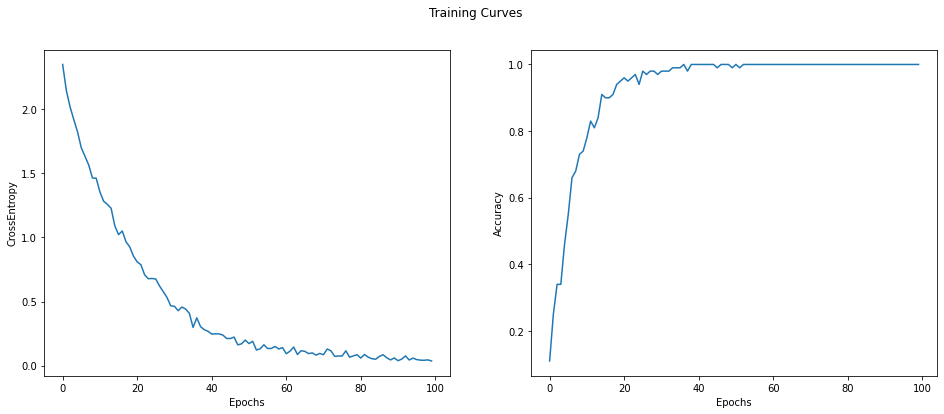

In [ ]:
# Plot training and accuracy
fig, axs = plt.subplots(1,2, figsize=(16,6))
fig.suptitle("Training Curves")

axs[0].plot(train_loss)
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("CrossEntropy")

axs[1].plot(train_accuracy)
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")

plt.show()

In [ ]:
print("Train Loss:",train_loss[-1])
print("Train Accuracy:",train_accuracy[-1])

Train Loss: 0.035881093889474865
Train Accuracy: 1.0


In [ ]:
# Compute test loss and accuracy
resnet.eval()

test_losses, test_accuracies = [], []

for j, (x,y) in enumerate(test_loader):

      input_, target_ = x.to(device), y.to(device)
      with torch.no_grad():
          out = resnet(input_) # Forward pass
          loss = criterion(out,target_) # Compute loss
          loss_value = loss.item()
          test_losses.append(loss_value)

          prediction, target_arr = torch.argmax(out, dim=1).cpu().detach().numpy(), target_.cpu().detach().numpy()
          accuracy = accuracy_score(target_arr, prediction) # Compute accuracy
          test_accuracies.append(accuracy)

test_loss = np.mean(test_losses)
test_accuracy = np.mean(test_accuracies)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Test Loss: 2.2740118684768675
Test Accuracy: 0.21940000000000004


We obtain the following baseline results (using parameters suggested by the question):

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   Baseline ResNet-18  | 100 | 100\% | 21.9\% |

This shows how poorly our model generalizes when trained on a small amount of data.

We now set up a 10-fold cross-validation pipeline in order to tune the model. We will attempt to tune batch size, along with learning rate schedule.

We make use of a multi-step learning rate scheduler in order to decrease learning rate over epochs. In order to limit tuning parameters (due to limitations in computational power), we will tune learning rate and decay factor. The scheduler will decay learning rate each 5 epochs for large values of gamma and 10 epochs for smaller values.

We train our models over 40 epochs each and use a best model callback to use the model that performed best over all validation data, over all models and all epochs.

In [ ]:
# Setting up the k-fold
k = 10
kfold = KFold(n_splits=k, shuffle=True, random_state=42)

In [ ]:
# Instantiating training parameters
params = {
    'batch_size': [5,10,15,30,45,5,10,15,30,45],
    'lr': [0.001,0.001,0.01,0.01,0.1,0.01,0.01,0.1,0.1,1.],
    'gamma':[0.8,0.5,0.5,0.5,0.1,0.5,0.8,0.1,0.5,0.1],
    'decay_step':[5,5,5,5,10,5,5,10,5,10]
}

epochs = 100

In [ ]:
start = time.time()

best_model_dict, best_accuracy, best_loss, best_fold, best_epoch = None, 0, None, None, None # Keep best model and accuracy
train_loss_curves, train_accuracy_curves = [], []
val_loss_curves, val_accuracy_curves = [], []

for fold, (train_ids, test_ids) in enumerate(kfold.split(train_dataset)):
    
    # Sample train_dataset into train fold and validation fold
    train_fold = torch.utils.data.Subset(train_dataset, train_ids)
    validation_fold = torch.utils.data.Subset(train_dataset, test_ids)

    # Instantiate model
    resnet = ResNet18()

    # Instantiate training parameters
    batch_size = params['batch_size'][fold]
    lr = params['lr'][fold]
    optimizer = torch.optim.SGD(resnet.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss() # Use cross-entropy as loss function
    milestones = list(range(0,41,params['decay_step'][fold]))[1:]
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=params['gamma'][fold])
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Send to model
    resnet.to(device)

    # Instantiate batches
    torch.manual_seed(0) # Set random seed for reproducibility purposes
    train_loader = torch.utils.data.DataLoader(train_fold, batch_size=batch_size,
                                            shuffle=True, num_workers=2)
    val_loader = torch.utils.data.DataLoader(validation_fold, batch_size=10,
                                            shuffle=False, num_workers=2)

    # Start training
    train_loss, train_accuracy = [], []
    validation_loss, validation_accuracy = [], []
    epoch = 0

    for i in range(epochs):
        # Epoch counter
        epoch += 1
        # Train model
        resnet.train()

        # Run through each batch of data
        batch_losses, batch_accuracy = [], []
        batch_sizes = []
        batch_iter = enumerate(train_loader)

        for j, (x,y) in batch_iter:
            
            input_, target_ = x.to(device), y.to(device)
            optimizer.zero_grad() # Zerograd the parameters
            out = resnet(input_) # Forward pass
            loss = criterion(out,target_) # Compute loss
            loss_value = loss.item()
            batch_losses.append(loss_value)
            loss.backward() # Backward pass
            optimizer.step() # Update params
            prediction, target_arr = torch.argmax(out, dim=1).cpu().detach().numpy(), target_.cpu().detach().numpy()
            accuracy = accuracy_score(target_arr, prediction) # Compute accuracy
            batch_accuracy.append(accuracy)
            batch_sizes.append(y.shape[0]/batch_size) # Final loss and accuracy are weighted means relative to batch size

        train_loss.append(np.sum(np.multiply(batch_losses,batch_sizes) / np.sum(batch_sizes)))
        train_accuracy.append(np.sum(np.multiply(batch_accuracy,batch_sizes) / np.sum(batch_sizes)))
        scheduler.step() # Update learning rate using scheduler
        print("Model {} - Training - Epoch {}: (accuracy: {}, loss: {})".format(fold,epoch,round(train_accuracy[-1],2),round(train_loss[-1],2))) # Update progressbar

        # Validation
        resnet.eval() # Evaluation mode
        val_losses, val_accuracy = [], []
        batch_iter = enumerate(val_loader)

        for j, (x,y) in batch_iter:
            input_, target_ = x.to(device), y.to(device)
            
            with torch.no_grad():
                out = resnet(input_) # Forward pass
                loss = criterion(out,target_) # Compute loss
                loss_value = loss.item()
                val_losses.append(loss_value)
                prediction, target_arr = torch.argmax(out, dim=1).cpu().detach().numpy(), target_.cpu().detach().numpy()
                accuracy = accuracy_score(target_arr, prediction) # Compute accuracy
                val_accuracy.append(accuracy)
        
        validation_loss.append(np.mean(val_losses))
        validation_accuracy.append(np.mean(val_accuracy))
        print("Model {} - Validation - Epoch {}: (accuracy: {}, loss: {})".format(fold,epoch,round(validation_accuracy[-1],2),round(validation_loss[-1],2)))

        # Check for best model
        if best_accuracy < validation_accuracy[-1]:
            best_model_dict, best_accuracy, best_loss, best_fold, best_epoch = resnet.state_dict().copy(), validation_accuracy[-1], validation_loss[-1], fold, epoch
        elif best_accuracy == validation_accuracy[-1] and best_loss >= validation_loss[-1]:
            best_model_dict, best_accuracy, best_loss, best_fold, best_epoch = resnet.state_dict().copy(), validation_accuracy[-1], validation_loss[-1], fold, epoch

    # Update learning curves
    train_loss_curves.append(train_loss)
    train_accuracy_curves.append(train_accuracy)
    val_loss_curves.append(validation_loss)
    val_accuracy_curves.append(validation_accuracy)

stop = time.time()
print("Training Time:", round(stop-start,2),"seconds")

Model 0 - Training - Epoch 1: (accuracy: 0.09, loss: 2.32)
Model 0 - Validation - Epoch 1: (accuracy: 0.1, loss: 2.29)
Model 0 - Training - Epoch 2: (accuracy: 0.23, loss: 2.12)
Model 0 - Validation - Epoch 2: (accuracy: 0.1, loss: 2.34)
Model 0 - Training - Epoch 3: (accuracy: 0.39, loss: 1.98)
Model 0 - Validation - Epoch 3: (accuracy: 0.0, loss: 2.32)
Model 0 - Training - Epoch 4: (accuracy: 0.44, loss: 1.85)
Model 0 - Validation - Epoch 4: (accuracy: 0.2, loss: 2.24)
Model 0 - Training - Epoch 5: (accuracy: 0.48, loss: 1.77)
Model 0 - Validation - Epoch 5: (accuracy: 0.2, loss: 2.29)
Model 0 - Training - Epoch 6: (accuracy: 0.48, loss: 1.72)
Model 0 - Validation - Epoch 6: (accuracy: 0.2, loss: 2.27)
Model 0 - Training - Epoch 7: (accuracy: 0.6, loss: 1.61)
Model 0 - Validation - Epoch 7: (accuracy: 0.1, loss: 2.22)
Model 0 - Training - Epoch 8: (accuracy: 0.64, loss: 1.5)
Model 0 - Validation - Epoch 8: (accuracy: 0.1, loss: 2.24)
Model 0 - Training - Epoch 9: (accuracy: 0.7, loss

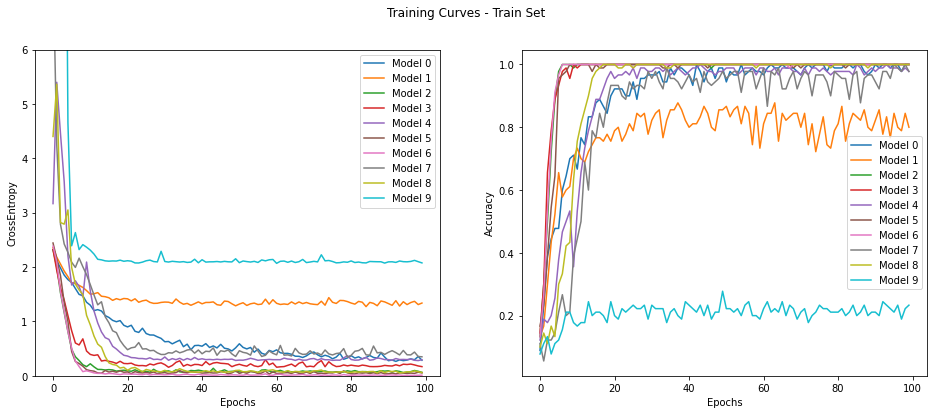

In [ ]:
# Plot training and accuracy
fig, axs = plt.subplots(1,2, figsize=(16,6))
fig.suptitle("Training Curves - Train Set")

for fold, train_loss in enumerate(train_loss_curves):
  axs[0].plot(train_loss, label="Model {}".format(fold))
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("CrossEntropy")
axs[0].legend()
axs[0].set_ylim(0,6)

for fold, train_accuracy in enumerate(train_accuracy_curves):
  axs[1].plot(train_accuracy, label="Model {}".format(fold))
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].legend()

plt.show()

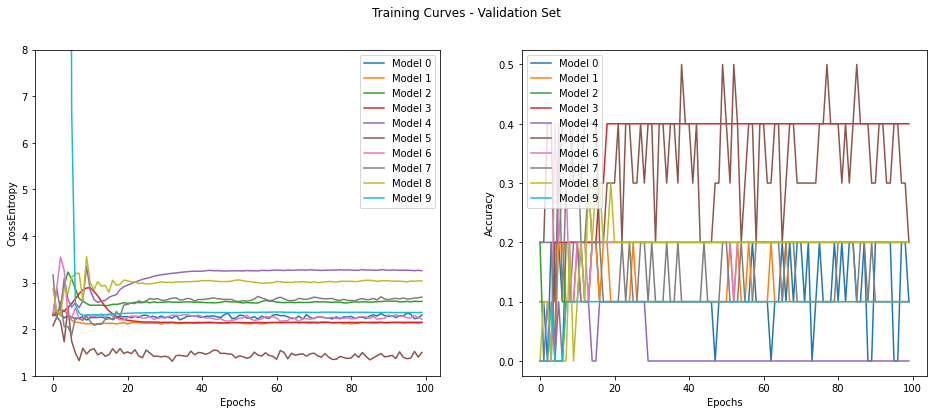

In [ ]:
# Plot training and accuracy
fig, axs = plt.subplots(1,2, figsize=(16,6))
fig.suptitle("Training Curves - Validation Set")

for fold, val_loss in enumerate(val_loss_curves):
  axs[0].plot(val_loss, label="Model {}".format(fold))
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("CrossEntropy")
axs[0].legend()
axs[0].set_ylim(1,8)

for fold, val_accuracy in enumerate(val_accuracy_curves):
  axs[1].plot(val_accuracy, label="Model {}".format(fold))
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].legend()

plt.show()

In [ ]:
print("Best Model: {}".format(best_fold))
print("Best Model Parameters: {} Batch Size - {} Learning Rate - {} Decay Factor - {} Decay Step".format(params['batch_size'][fold],params['lr'][fold],params['gamma'][fold],params['decay_step'][fold]))
print("Best Epoch: {}".format(best_epoch))
print("Best Validation Accuracy: {}".format(best_accuracy))

Best Model: 5
Best Model Parameters: 45 Batch Size - 1.0 Learning Rate - 0.1 Decay Factor - 10 Decay Step
Best Epoch: 86
Best Validation Accuracy: 0.5


In [ ]:
# Load best model from state dictionary
resnet = ResNet18()
resnet.load_state_dict(best_model_dict)
resnet.to(device)
print("Model sent to GPU!")

Model sent to GPU!


In [ ]:
# Compute test loss and accuracy
resnet.eval()

test_losses, test_accuracies = [], []

for j, (x,y) in enumerate(test_loader):

      input_, target_ = x.to(device), y.to(device)
      with torch.no_grad():
          out = resnet(input_) # Forward pass
          loss = criterion(out,target_) # Compute loss
          loss_value = loss.item()
          test_losses.append(loss_value)

          prediction, target_arr = torch.argmax(out, dim=1).cpu().detach().numpy(), target_.cpu().detach().numpy()
          accuracy = accuracy_score(target_arr, prediction) # Compute accuracy
          test_accuracies.append(accuracy)

test_loss = np.mean(test_losses)
test_accuracy = np.mean(test_accuracies)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Test Loss: 2.496555259466171
Test Accuracy: 0.2466


After 10-fold cross-validation. We are able to significantly improve model performance. Using our best model, we obtain the following results:

| Model | Number of  epochs  | Train accuracy | Validation accuracy | Test accuracy |
|------|------|------|------|------|
|   Cross-Validated ResNet-18  | 100 | 100\% | 50\% | 24.66\% |

# Transfer learning

We propose to use pre-trained models on a classification task, in order to improve the results of our setting.

## ImageNet features

Now, we will use a model pre-trained on ImageNet and see how well it performs on CIFAR. A list of ImageNet pre-trained models is available on : https://pytorch.org/vision/stable/models.html

__Question 4 (3 points) :__ Pick a model from the list above, adapt it for CIFAR and retrain its final layer (or a block of layers, depending on the resources to which you have access to). Report its accuracy.

We will use the pretrained ResNet-18 model in order to compare results with the model computed above. We will train the final layer of the model thus much less parameters will be trained. We cannot use the training parameters used in the previous question as it will probably overfit our data. We once again use cross-validation to obtain best training parameters. 

Pytorch's CNNs were pretrained on images of size (224,224), we thus increase our images' size in order to match the input dimensions.

In [ ]:
# CIFAR-10 needs to be transformed to torch Tensor and normalized
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     transforms.Resize(224)])

# Downloading full train dataset
cifar_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)

# Splitting into first 100 images and the rest
train_dataset = torch.utils.data.Subset(cifar_dataset, range(100))
nolabel_dataset = torch.utils.data.Subset(cifar_dataset, range(100,len(cifar_dataset)))

# Downloading full test dataset
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100,
                                            shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Setting up the k-fold
k = 10
kfold = KFold(n_splits=k, shuffle=True, random_state=42)

In [ ]:
# Instantiating training parameters
params = {
    'batch_size': [30,30,30,30,45,45,45,45,90,90],
    'lr': [1.,0.1,0.1,0.001,1.,0.1,0.1,0.001,1.,0.1],
    'gamma':[0.1,0.5,0.1,0.1,0.1,0.5,0.1,0.1,0.1,0.1],
    'decay_step':[5,5,10,10,5,5,10,10,5,5]
}

epochs = 100

Though training on CPU is still possible with images of size (224,224), we make use of GPUs to decrease significantly training time. 

In [ ]:
# Start training over 10-folds
start = time.time()

best_model_dict, best_accuracy, best_loss, best_fold, best_epoch = None, 0, None, None, None # Keep best model and accuracy
train_loss_curves, train_accuracy_curves = [], []
val_loss_curves, val_accuracy_curves = [], []

for fold, (train_ids, test_ids) in enumerate(kfold.split(train_dataset)):
    
    # Sample train_dataset into train fold and validation fold
    train_fold = torch.utils.data.Subset(train_dataset, train_ids)
    validation_fold = torch.utils.data.Subset(train_dataset, test_ids)

    # Instantiate model and reinitialize last layer
    resnet = models.resnet18(pretrained = True)
    resnet.fc = nn.Linear(512,10)

    # Instantiate training parameters
    batch_size = params['batch_size'][fold]
    lr = params['lr'][fold]
    optimizer = torch.optim.SGD(resnet.fc.parameters(), lr=lr) # Train last layer
    criterion = nn.CrossEntropyLoss() # Use cross-entropy as loss function
    milestones = list(range(0,41,params['decay_step'][fold]))[1:]
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=params['gamma'][fold])
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Send model to GPU
    resnet.to(device)

    # Instantiate batches
    torch.manual_seed(0) # Set random seed for reproducibility purposes
    train_loader = torch.utils.data.DataLoader(train_fold, batch_size=batch_size,
                                            shuffle=True, num_workers=2)
    val_loader = torch.utils.data.DataLoader(validation_fold, batch_size=10,
                                            shuffle=False, num_workers=2)

    # Start training
    train_loss, train_accuracy = [], []
    validation_loss, validation_accuracy = [], []
    epoch = 0

    for i in range(epochs):
        # Epoch counter
        epoch += 1
        # Train model
        resnet.train()

        # Run through each batch of data
        batch_losses, batch_accuracy = [], []
        batch_sizes = []
        batch_iter = enumerate(train_loader)

        for j, (x,y) in batch_iter:
            
            input_, target_ = x.to(device), y.to(device)
            optimizer.zero_grad() # Zerograd the parameters
            out = resnet(input_) # Forward pass
            loss = criterion(out,target_) # Compute loss
            loss_value = loss.item()
            batch_losses.append(loss_value)
            loss.backward() # Backward pass
            optimizer.step() # Update params
            prediction, target_arr = torch.argmax(out, dim=1).cpu().detach().numpy(), target_.cpu().detach().numpy()
            accuracy = accuracy_score(target_arr, prediction) # Compute accuracy
            batch_accuracy.append(accuracy)
            batch_sizes.append(y.shape[0]/batch_size) # Final loss and accuracy are weighted means relative to batch size

        train_loss.append(np.sum(np.multiply(batch_losses,batch_sizes) / np.sum(batch_sizes)))
        train_accuracy.append(np.sum(np.multiply(batch_accuracy,batch_sizes) / np.sum(batch_sizes)))
        scheduler.step() # Update learning rate using scheduler
        print("Model {} - Training - Epoch {}: (accuracy: {}, loss: {})".format(fold,epoch,round(train_accuracy[-1],2),round(train_loss[-1],2))) # Update progressbar

        # Validation
        resnet.eval() # Evaluation mode
        val_losses, val_accuracy = [], []
        batch_iter = enumerate(val_loader)

        for j, (x,y) in batch_iter:
            input_, target_ = x.to(device), y.to(device)
            
            with torch.no_grad():
                out = resnet(input_) # Forward pass
                loss = criterion(out,target_) # Compute loss
                loss_value = loss.item()
                val_losses.append(loss_value)
                prediction, target_arr = torch.argmax(out, dim=1).cpu().detach().numpy(), target_.cpu().detach().numpy()
                accuracy = accuracy_score(target_arr, prediction) # Compute accuracy
                val_accuracy.append(accuracy)
        
        validation_loss.append(np.mean(val_losses))
        validation_accuracy.append(np.mean(val_accuracy))
        print("Model {} - Validation - Epoch {}: (accuracy: {}, loss: {})".format(fold,epoch,round(validation_accuracy[-1],2),round(validation_loss[-1],2)))

        # Check for best model
        if best_accuracy < validation_accuracy[-1]:
            best_model_dict, best_accuracy, best_loss, best_fold, best_epoch = resnet.state_dict().copy(), validation_accuracy[-1], validation_loss[-1], fold, epoch
        elif best_accuracy == validation_accuracy[-1] and best_loss >= validation_loss[-1]:
            best_model_dict, best_accuracy, best_loss, best_fold, best_epoch = resnet.state_dict().copy(), validation_accuracy[-1], validation_loss[-1], fold, epoch

    # Update learning curves
    train_loss_curves.append(train_loss)
    train_accuracy_curves.append(train_accuracy)
    val_loss_curves.append(validation_loss)
    val_accuracy_curves.append(validation_accuracy)

stop = time.time()
print("Training Time:", round(stop-start,2),"seconds")

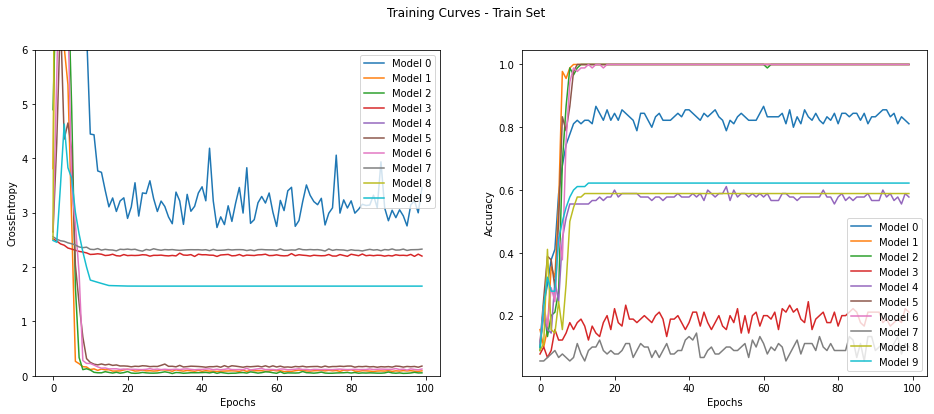

In [ ]:
# Plot training and accuracy
fig, axs = plt.subplots(1,2, figsize=(16,6))
fig.suptitle("Training Curves - Train Set")

for fold, train_loss in enumerate(train_loss_curves):
  axs[0].plot(train_loss, label="Model {}".format(fold))
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("CrossEntropy")
axs[0].legend()
axs[0].set_ylim(0,6)

for fold, train_accuracy in enumerate(train_accuracy_curves):
  axs[1].plot(train_accuracy, label="Model {}".format(fold))
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].legend()

plt.show()

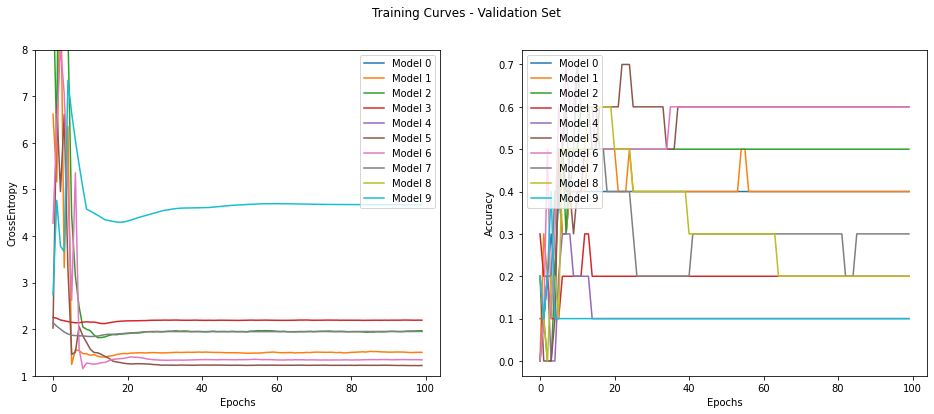

In [ ]:
# Plot training and accuracy
fig, axs = plt.subplots(1,2, figsize=(16,6))
fig.suptitle("Training Curves - Validation Set")

for fold, val_loss in enumerate(val_loss_curves):
  axs[0].plot(val_loss, label="Model {}".format(fold))
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("CrossEntropy")
axs[0].legend()
axs[0].set_ylim(1,8)

for fold, val_accuracy in enumerate(val_accuracy_curves):
  axs[1].plot(val_accuracy, label="Model {}".format(fold))
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].legend()

plt.show()

In [ ]:
print("Best Model: {}".format(best_fold))
print("Best Model Parameters: {} Batch Size - {} Learning Rate - {} Decay Factor - {} Decay Step".format(params['batch_size'][fold],params['lr'][fold],params['gamma'][fold],params['decay_step'][fold]))
print("Best Epoch: {}".format(best_epoch))
print("Best Validation Accuracy: {}".format(best_accuracy))

Best Model: 5
Best Model Parameters: 90 Batch Size - 0.1 Learning Rate - 0.1 Decay Factor - 5 Decay Step
Best Epoch: 25
Best Validation Accuracy: 0.7


In [ ]:
# Load best model from state dictionary
resnet = models.resnet18()
resnet.fc = nn.Linear(512,10)
resnet.load_state_dict(best_model_dict)
resnet.to(device)
print("Model sent to GPU!")

Model sent to GPU!


In [ ]:
# Compute test loss and accuracy
resnet.eval()

test_losses, test_accuracies = [], []

for j, (x,y) in enumerate(test_loader):

      input_, target_ = x.to(device), y.to(device)
      with torch.no_grad():
          out = resnet(input_) # Forward pass
          loss = criterion(out,target_) # Compute loss
          loss_value = loss.item()
          test_losses.append(loss_value)

          prediction, target_arr = torch.argmax(out, dim=1).cpu().detach().numpy(), target_.cpu().detach().numpy()
          accuracy = accuracy_score(target_arr, prediction) # Compute accuracy
          test_accuracies.append(accuracy)

test_loss = np.mean(test_losses)
test_accuracy = np.mean(test_accuracies)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Test Loss: 1.3395110595226287
Test Accuracy: 0.537


Model improves significantly while using Transfer Learning. By simply training the model's last layer, we are able to obtain significant improvement compared to a model trained from scratch. Our best model performs as follows:

| Model | Number of  epochs  | Train accuracy | Validation accuracy | Test accuracy |
|------|------|------|------|------|
|   Pre-Trained ResNet-18  | 100 | 100\% | 70\% | 53.7\% |

# Incorporating priors
Geometrical priors are appealing for image classification tasks. 
A color image $x$ can be seen as a function: $\mathbb{S}\rightarrow\mathbb{R}^3$, where $\mathbb{S} \subset \mathbb{R}^2$ is the image support.
Let us consider transformations $\mathcal{T}$ of possible inputs $x$. For instance, if an image had infinite support, a translation $\mathcal{T}_a$ of an image $x$ by a shift $a$ would lead to a new infinite-support image $\mathcal{T}_a(x)$, described at each pixel $u$ by :

$$\forall u, \mathcal{T}_a(x)(u)=x(u-a)\,.$$

__Question 5 (1.5 points) :__ Explain the issues when dealing with translations, rotations, scaling effects, color changes on $32\times32$ images. Propose several ideas to tackle them.

The issue with a small size image is that it is more easy to lose information and more difficult to gain information.


*   Difficult to gain more information as the result of the transformation will have a lower impact as they are not enough pixel on the images. Do a rotation of the image of a car in the center of the picture, most of the car pixel will still be in the picture. 
*   Easier to lose information as the image is so small that doing a translation or a crop for example will lead to an image with not enough information left.

## Data augmentations

__Question 6 (3 points) :__ Propose a set of geometric transformations beyond translation, and incorporate them in your training pipeline. Train the model of the __Question 3__ with them and report the accuracies.
You can use tools from https://pytorch.org/vision/stable/transforms.html 

We first intended to apply a pre-determined list of image transformations to the data. Indeed, this paper (https://arxiv.org/pdf/1805.09501.pdf) has produced a set of transformations aiming to optimize training on the CIFAR10 dataset. Unfortunately, most of the transformations are image processing methods rather than simple geometric transformations. 

We thus decide to implement our own augmentation pipeline. It will contain a set of random geometric transformations: horizontal and vertical flips and rotations. Using this augmented dataset, we train the last layer of Pytorch's pretrained ResNet18.

In [ ]:
# In this question, we use the Subset class of utils.data to consider the first 100 samples of CIFAR-10
# Our unlabeled dataset is also generated using this method

# CIFAR-10 needs to be transformed to torch Tensor and normalized
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     transforms.Resize(224)])

transform_augment = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     transforms.Resize(224),
     transforms.RandomHorizontalFlip(),
     transforms.RandomVerticalFlip(),
     transforms.RandomRotation(5)])

# Downloading full train dataset
cifar_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)

cifar_augment_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform_augment)

# Splitting into first 100 images and the rest
train_dataset = torch.utils.data.Subset(cifar_dataset, range(100))
train_augment_dataset = torch.utils.data.Subset(cifar_augment_dataset, range(100))

# Downloading full test dataset
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transform)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10,
                                            shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


We then retrain model of Question 3 using 10-fold cross-validation.

In [ ]:
# Setting up the k-fold
k = 10
kfold = KFold(n_splits=k, shuffle=True, random_state=42)

In [ ]:
# Instantiating training parameters
params = {
    'batch_size': [15,15,15,15,30,30,30,30,45,45],
    'lr': [1.,0.1,0.1,0.001,1.,0.1,0.1,0.001,1.,0.1],
    'gamma':[0.1,0.5,0.1,0.1,0.1,0.5,0.1,0.1,0.1,0.1],
    'decay_step':[5,5,10,10,5,5,10,10,5,5]
}

epochs = 100

In [ ]:
start = time.time()

best_model_dict, best_accuracy, best_loss, best_fold, best_epoch = None, 0, None, None, None # Keep best model and accuracy
train_loss_curves, train_accuracy_curves = [], []
val_loss_curves, val_accuracy_curves = [], []

for fold, (train_ids, test_ids) in enumerate(kfold.split(train_dataset)):
    
    # Sample train_dataset into train fold and validation fold
    train_fold = torch.utils.data.Subset(train_augment_dataset, train_ids)
    validation_fold = torch.utils.data.Subset(train_dataset, test_ids) # Consider unchanged images as validation set

    # Instantiate model
    resnet = models.resnet18(pretrained = True)
    resnet.fc = nn.Linear(512,10)

    # Instantiate training parameters
    batch_size = params['batch_size'][fold]
    lr = params['lr'][fold]
    optimizer = torch.optim.SGD(resnet.fc.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss() # Use cross-entropy as loss function
    milestones = list(range(0,41,params['decay_step'][fold]))[1:]
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=params['gamma'][fold])
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Send to GPU
    resnet.to(device)

    # Instantiate batches
    torch.manual_seed(0) # Set random seed for reproducibility purposes
    train_loader = torch.utils.data.DataLoader(train_fold, batch_size=batch_size,
                                            shuffle=True, num_workers=2)
    val_loader = torch.utils.data.DataLoader(validation_fold, batch_size=10,
                                            shuffle=False, num_workers=2)

    # Start training
    train_loss, train_accuracy = [], []
    validation_loss, validation_accuracy = [], []
    epoch = 0

    for i in range(epochs):
        # Epoch counter
        epoch += 1
        # Train model
        resnet.train()

        # Run through each batch of data
        batch_losses, batch_accuracy = [], []
        batch_sizes = []
        batch_iter = enumerate(train_loader)

        for j, (x,y) in batch_iter:
            
            input_, target_ = x.to(device), y.to(device)
            optimizer.zero_grad() # Zerograd the parameters
            out = resnet(input_) # Forward pass
            loss = criterion(out,target_) # Compute loss
            loss_value = loss.item()
            batch_losses.append(loss_value)
            loss.backward() # Backward pass
            optimizer.step() # Update params
            prediction, target_arr = torch.argmax(out, dim=1).cpu().detach().numpy(), target_.cpu().detach().numpy()
            accuracy = accuracy_score(target_arr, prediction) # Compute accuracy
            batch_accuracy.append(accuracy)
            batch_sizes.append(y.shape[0]/batch_size) # Final loss and accuracy are weighted means relative to batch size

        train_loss.append(np.sum(np.multiply(batch_losses,batch_sizes) / np.sum(batch_sizes)))
        train_accuracy.append(np.sum(np.multiply(batch_accuracy,batch_sizes) / np.sum(batch_sizes)))
        scheduler.step() # Update learning rate using scheduler
        print("Model {} - Training - Epoch {}: (accuracy: {}, loss: {})".format(fold,epoch,round(train_accuracy[-1],2),round(train_loss[-1],2))) # Update progressbar

        # Validation
        resnet.eval() # Evaluation mode
        val_losses, val_accuracy = [], []
        batch_iter = enumerate(val_loader)

        for j, (x,y) in batch_iter:
            input_, target_ = x.to(device), y.to(device)
            
            with torch.no_grad():
                out = resnet(input_) # Forward pass
                loss = criterion(out,target_) # Compute loss
                loss_value = loss.item()
                val_losses.append(loss_value)
                prediction, target_arr = torch.argmax(out, dim=1).cpu().detach().numpy(), target_.cpu().detach().numpy()
                accuracy = accuracy_score(target_arr, prediction) # Compute accuracy
                val_accuracy.append(accuracy)
        
        validation_loss.append(np.mean(val_losses))
        validation_accuracy.append(np.mean(val_accuracy))
        print("Model {} - Validation - Epoch {}: (accuracy: {}, loss: {})".format(fold,epoch,round(validation_accuracy[-1],2),round(validation_loss[-1],2)))

        # Check for best model
        if best_accuracy < validation_accuracy[-1]:
            best_model_dict, best_accuracy, best_loss, best_fold, best_epoch = resnet.state_dict().copy(), validation_accuracy[-1], validation_loss[-1], fold, epoch
        elif best_accuracy == validation_accuracy[-1] and best_loss >= validation_loss[-1]:
            best_model_dict, best_accuracy, best_loss, best_fold, best_epoch = resnet.state_dict().copy(), validation_accuracy[-1], validation_loss[-1], fold, epoch

    # Update learning curves
    train_loss_curves.append(train_loss)
    train_accuracy_curves.append(train_accuracy)
    val_loss_curves.append(validation_loss)
    val_accuracy_curves.append(validation_accuracy)

stop = time.time()
print("Training Time:", round(stop-start,2),"seconds")

Model 0 - Training - Epoch 1: (accuracy: 0.11, loss: 114.97)
Model 0 - Validation - Epoch 1: (accuracy: 0.1, loss: 168.36)
Model 0 - Training - Epoch 2: (accuracy: 0.19, loss: 141.92)
Model 0 - Validation - Epoch 2: (accuracy: 0.0, loss: 105.7)
Model 0 - Training - Epoch 3: (accuracy: 0.12, loss: 143.87)
Model 0 - Validation - Epoch 3: (accuracy: 0.4, loss: 118.42)
Model 0 - Training - Epoch 4: (accuracy: 0.2, loss: 111.81)
Model 0 - Validation - Epoch 4: (accuracy: 0.1, loss: 114.3)
Model 0 - Training - Epoch 5: (accuracy: 0.24, loss: 66.11)
Model 0 - Validation - Epoch 5: (accuracy: 0.3, loss: 59.41)
Model 0 - Training - Epoch 6: (accuracy: 0.42, loss: 38.15)
Model 0 - Validation - Epoch 6: (accuracy: 0.3, loss: 39.43)
Model 0 - Training - Epoch 7: (accuracy: 0.54, loss: 15.66)
Model 0 - Validation - Epoch 7: (accuracy: 0.4, loss: 27.52)
Model 0 - Training - Epoch 8: (accuracy: 0.68, loss: 7.24)
Model 0 - Validation - Epoch 8: (accuracy: 0.4, loss: 21.71)
Model 0 - Training - Epoch 9

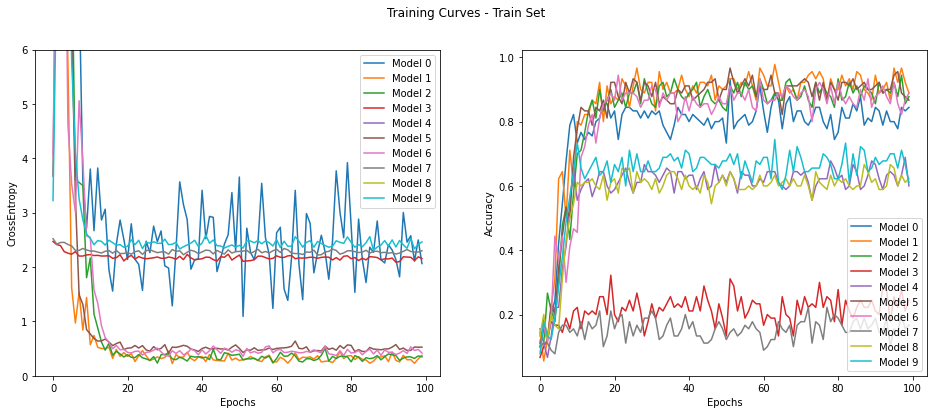

In [ ]:
# Plot training and accuracy
fig, axs = plt.subplots(1,2, figsize=(16,6))
fig.suptitle("Training Curves - Train Set")

for fold, train_loss in enumerate(train_loss_curves):
  axs[0].plot(train_loss, label="Model {}".format(fold))
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("CrossEntropy")
axs[0].legend()
axs[0].set_ylim(0,6)

for fold, train_accuracy in enumerate(train_accuracy_curves):
  axs[1].plot(train_accuracy, label="Model {}".format(fold))
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].legend()

plt.show()

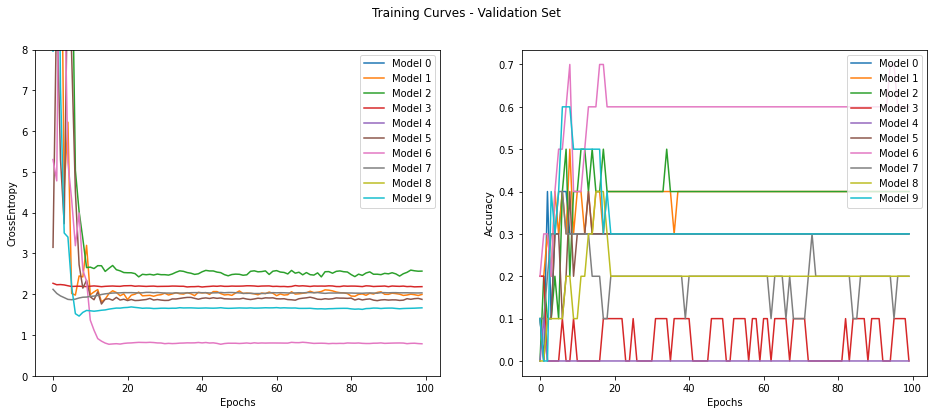

In [ ]:
# Plot training and accuracy
fig, axs = plt.subplots(1,2, figsize=(16,6))
fig.suptitle("Training Curves - Validation Set")

for fold, val_loss in enumerate(val_loss_curves):
  axs[0].plot(val_loss, label="Model {}".format(fold))
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("CrossEntropy")
axs[0].legend()
axs[0].set_ylim(0,8)

for fold, val_accuracy in enumerate(val_accuracy_curves):
  axs[1].plot(val_accuracy, label="Model {}".format(fold))
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].legend()

plt.show()

In [ ]:
print("Best Model: {}".format(best_fold))
print("Best Model Parameters: {} Batch Size - {} Learning Rate - {} Decay Factor - {} Decay Step".format(params['batch_size'][fold],params['lr'][fold],params['gamma'][fold],params['decay_step'][fold]))
print("Best Epoch: {}".format(best_epoch))
print("Best Validation Accuracy: {}".format(best_accuracy))

Best Model: 6
Best Model Parameters: 45 Batch Size - 0.1 Learning Rate - 0.1 Decay Factor - 5 Decay Step
Best Epoch: 17
Best Validation Accuracy: 0.7


In [ ]:
# Load best model from state dictionary
resnet = models.resnet18(pretrained=True)
resnet.fc = nn.Linear(512,10)
resnet.load_state_dict(best_model_dict)
resnet.to(device)
print("Model sent to GPU!")

Model sent to GPU!


In [ ]:
# Compute test loss and accuracy
resnet.eval()

test_losses, test_accuracies = [], []

for j, (x,y) in enumerate(test_loader):

      input_, target_ = x.to(device), y.to(device)
      with torch.no_grad():
          out = resnet(input_) # Forward pass
          loss = criterion(out,target_) # Compute loss
          loss_value = loss.item()
          test_losses.append(loss_value)

          prediction, target_arr = torch.argmax(out, dim=1).cpu().detach().numpy(), target_.cpu().detach().numpy()
          accuracy = accuracy_score(target_arr, prediction) # Compute accuracy
          test_accuracies.append(accuracy)

test_loss = np.mean(test_losses)
test_accuracy = np.mean(test_accuracies)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Test Loss: 1.470351928949356
Test Accuracy: 0.49639999999999995


Unsurprisingly, our model's performance decreases from the non-augmented, transfer learned model. As stated in  **Question 5**,  applying geometrical transformations (such as rotations) to small images decreases significantly the information contained in each image (even if those images are upscaled to a greater size). Therefore, we obtain the following results using the augmented data:

| Model | Number of  epochs  | Train accuracy | Validation accuracy | Test accuracy |
|------|------|------|------|------|
|   Pre-Trained, Augmented ResNet-18  | 100 | 100\% | 70\% | 49.6\% |

# Conclusions

__Question 7 (5 points) :__ Write a short report explaining the pros and the cons of each method you implemented. 25% of the grade of this project will correspond to this question, thus, it should be done carefully. In particular, please add a plot that will summarize all your numerical results.

To conclude this fourth TP, we conducted various experiment to palliate a lack of training data (in our case only 100 labeled data points). We have tried several approach, all of them with advantages and drawbacks. With the baseline ResNet18 model, we have an accuracy on the training set of 100%, while for the test set we have 22%. We have clearly an overfitting issue, which is normal with so few data points.

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   Baseline ResNet-18  | 100 | 100\% | 21.9\% |

Transfer learning: it is a 'sequential training' approach. The Resnet18 has been already trained on a huge dataset. We pick the model, modify the last layer to correspond to our output space, and we train again on our dataset. It helps to get good features on our small dataset. In our case it was the most successful approach as we reached an accuracy on the test set of 55%.
*   The advantages: get good feature from the previous training, faster training. Very easy to implement.
*   Drawbacks: we need to find a pretrained model that was trained on an auxiliary task that is similar than ours.

| Model | Number of  epochs  | Train accuracy | Validation accuracy | Test accuracy |
|------|------|------|------|------|
|   Pre-Trained ResNet-18  | 100 | 100\% | 70\% | 53.7\% |

Data augmentation: in this approach, we add various transformation to the real data. It can be either value based (color balance, noise...) or geometric (crop, rotation...). this approach allows to increase the number of data points. Yet, this approach, even though better than the baseline model, was inferior to transfer learning as we reached an accuracy on the test set of 49%.

*   Advantages: allows to get 'different' data points in addition to our original dataset. There are numerous way to do transformation, which means that we can drasticilally increase the size of our dataset. It is easy to implement.
*   Drawbacks: if the picture is too small in size, like what we have, it won't make a big impact. Moreover, depending on if the labels ar einvariant or equivariant, you must chose a transformation carefully. Picking a transformation must make sense. Rotating the picture of a dog make sense as you can have a picture of a dog layer on its back, the 4 pawns up for a belly rub. 

| Model | Number of  epochs  | Train accuracy | Validation accuracy | Test accuracy |
|------|------|------|------|------|
|   Pre-Trained, Augmented ResNet-18  | 100 | 100\% | 70\% | 49.6\% |

# Weak supervision

__Bonus \[open\] question (up to 4 points) :__ Pick a weakly supervised method that will potentially use $\mathcal{X}_{\text{nolabel}}\cup\mathcal{X}_{\text{train}}$ to train a model (a subset of $\mathcal{X}_{\text{nolabel}}$ is also fine). Evaluate it and report the accuracies. You should be careful in the choice of your method, in order to avoid heavy computational effort.